# Training a segmenation network

In [1]:
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import time
import datetime
import os
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from importlib import reload
import model_fcts as mod
import preprocessing_fcts as pp
import loss_fcts as loss

from seg_models import PixUnet, Custom_naderi_net, ASPP_net, ASPP_net512

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
EPOCHS = 10

In [3]:
def make_seg_ds(res, set_type, threshold = 0.01):
    """
    Make the dataset used to train and test the network
    Input : 
    -res : int, 256 or 512
    -set_type : 'train' or 'test'
    -threshold : float, used as threshold on the nDSM, used to generate the ground truth
    """
    ds_path = 'tf_dataset/' + set_type + '_dataset_rgb_' + str(res)
    ds = tf.data.Dataset.load(ds_path)
    ds = ds.map(lambda x, y: (x, x[:,:,0] - y)) #computes nDSM
    ds = ds.map(lambda x,y: (x, tf.cast(tf.math.greater(y, tf.constant(threshold)), dtype='float32'))) #apply threshold on the ndsm
    ds = ds.map(lambda x, y: (x, y*2-1))
    ds = ds.map(lambda x, y : (x, y, (tf.math.reduce_max(x[:,:,0]), tf.math.reduce_min(x[:,:,0])))) # Computes highest and lowest points from dsm for normalization
    ds = ds.map(lambda x, y, z:(tf.concat([tf.expand_dims(pp.normalize(x[:,:,0], z[0], z[1]), axis=-1),pp.normalize_rgb(x[:,:,1:])], axis=-1), tf.expand_dims(y, axis=-1))) #normalize separately the DSM and RGB input channels
    
    return ds

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.show()

def show_predictions(model, dataset=None, num=1):
    display([sample_image[:,:,1:], tf.expand_dims(sample_mask, axis=-1), model(tf.expand_dims(sample_image, axis=0),training=True)[0]])

In [ ]:
def new_tb_logfile(name):
    logdir = os.path.join("logs/SEG/", name)
    return tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, model, logs=None):
    print(model)
    clear_output(wait=True)
    show_predictions(model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    return None

def train_new_model(model, train_ds, test_ds, name, spe):
    """
    Trains a model
    -spe : int, steps per epoch
    """
    tensorboard_callback = new_tb_logfile(name)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy', 'Recall'])
    history =  model.fit(train_ds.repeat(), epochs=EPOCHS,
                          steps_per_epoch=spe,
                          validation_data=test_ds,
                          callbacks=[tensorboard_callback])
    ckpt_dir = 'training_checkpoints/seg/' + name
    checkpoint_prefix = os.path.join(ckpt_dir, "ckpt")
    os.mkdir(ckpt_dir)
    model_checkpoint = tf.train.Checkpoint(model=model)
    model_checkpoint.save(file_prefix=checkpoint_prefix)  
    return history

def new_net(net_type, inputs):
    return mod.Generator(inputs=inputs , outputs=net_type)

# Fraction of non ground points in the training set : 0.683
# Weight for non-ground : 1/0.683 = 1.465, for ground : 1/(1-0.683) = 3.153
def add_sample_weights(image, label):
    class_weights = tf.constant([3.153, 1.465])
    class_weights = class_weights / tf.reduce_sum(class_weights)
    
    sample_weights = tf.gather(class_weights, indices = tf.cast(label, tf.int32))
    return image, label, sample_weights

In [ ]:
#pix_nets = [{'net_model': 'PixUnet', 'res':256, 'batchSize':8, 'relu':False, 'activ':'sigmoid', 'name':'pix_sig'},
#            {'net_model': 'PixUnet', 'res':256, 'batchSize':8, 'relu':True, 'activ':'sigmoid', 'name':'pix_relu'},
#            {'net_model': 'Custom_naderi_net', 'res':256, 'batchSize':8, 'name':'naderi_net'},
#            {'net_model': 'ASPP_net', 'res':256, 'batchSize':8, 'name':'aspp_net'}] 
#            {'net_model': 'PixUnet', 'res':256, 'batchSize':1, 'relu':False, 'activ':'tanh', 'name':'pix_batch1'},
#            {'net_model': 'PixUnet', 'res':256, 'batchSize':4, 'relu':False, 'activ':'tanh', 'name':'pix_batch4'}, 
#            {'net_model': 'PixUnet', 'res':256, 'batchSize':8, 'relu':False, 'activ':'tanh', 'name':'pix_batch8'},
#pix_nets = [{'net_model': 'ASPP_net', 'res':256, 'batchSize':8, 'relu':True, 'activ':'sigmoid', 'name':'ASPP20ep'},
#           {'net_model': 'PixUnet', 'res':256, 'batchSize':8, as'activ':'sigmoid', 'name':'pix20ep'}]
#aspp_net = [{'net_model': 'ASPP_net', 'res':256, 'batchSize':8, 'relu':True, 'activ':'sigmoid', 'name':'ASPP_weighted', 'weighted':True}]
#final_batch_tests = [{'net_model': 'PixUnet', 'res':256, 'batchSize':2, 'relu':True, 'activ':'sigmoid', 'name':'fin_batch2'},
#                    {'net_model': 'PixUnet', 'res':256, 'batchSize':4, 'relu':True, 'activ':'sigmoid', 'name':'fin_batch4'},
#                    {'net_model': 'PixUnet', 'res':256, 'batchSize':16, 'relu':True, 'activ':'sigmoid', 'name':'fin_batch16'},]

In [ ]:
nets_to_train = [#{'net_model': 'ASPP_net', 'res':256, 'batchSize':8, 'relu':False, 'activ':'sigmoid', 'name':'leaky_ASPP'},
                #{'net_model': 'ASPP_net', 'res':256, 'batchSize':8, 'relu':False, 'activ':'sigmoid', 'name':'leaky_weighted_ASPP', 'weighted': True}
                  #{'net_model': 'PixUnet', 'res':256, 'batchSize':8, 'relu':False, 'activ':'sigmoid', 'name':'pix_sig_30'} 
                  #{'net_model': 'ASPP_net', 'res':512, 'batchSize':8, 'relu':True, 'activ':'sigmoid', 'name':'ASPP_15-02_512'}  
                    {'net_model': 'ASPP_net', 'res':512, 'batchSize':8, 'relu':True, 'activ':'sigmoid', 'name':'TEST'}
                    ]

In [ ]:
def train_models(segmentors_params):
    """
    Function to automatically train a series of networks with different parameters lists
    segmentors_params : dictionnary with the parameters of the network :
    -res
    -net_model : str, name of the function of a segmentation model defined in "seg_models.py"
    -batchSize : int
    -relu : bool, if false, leaky relu is used in the network
    -activ : str, activation function of the output layer
    -name : str
    """
    histories = []

    for params in segmentors_params:
        res = params['res']
        net_model = globals()[params['net_model']]
        batch_size = params['batchSize']
        
        inputs = tf.keras.layers.Input(shape=[res, res, 4])
        if params['net_model'] == 'PixUnet' or ['net_model'] == 'ASPP_net':
            net_type = net_model(inputs, relu=params['relu'], activ=params['activ'])
        else:
            net_type = net_model(inputs)
        
        segmentor = new_net(net_type, inputs)
        
        train_dataset = make_seg_ds(res, 'train')
        test_dataset =  make_seg_ds(res, 'test')
        
        if 'weighted' in params:
            if params['weighted']:
                train_dataset = train_dataset.map(add_sample_weights)
        
        train_ds = train_dataset.batch(batch_size)
        test_ds = test_dataset.batch(batch_size)
        
        if res == 256:
            train_length = 8708
        else:
            train_length = 2177
        
        
        spe = train_length // batch_size
                
        histories.append(train_new_model(segmentor, train_ds, test_ds, params['name'], spe))
        
    return histories

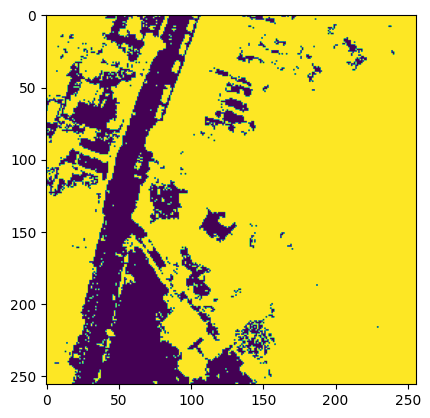

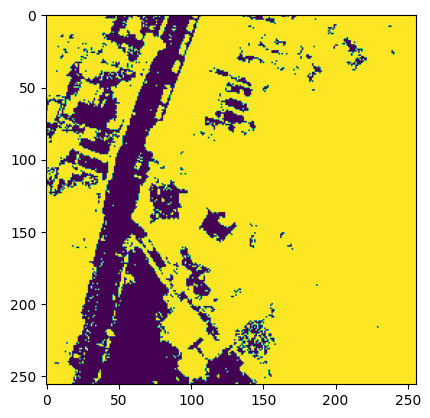

In [6]:
ds = make_seg_ds(256, 'train')
ds1 = make_seg_ds(256, 'train')
for i in ds.take(1):
    plt.imshow(i[1])
for i in ds1.take(1):
    plt.figure()
    plt.imshow(i[1])

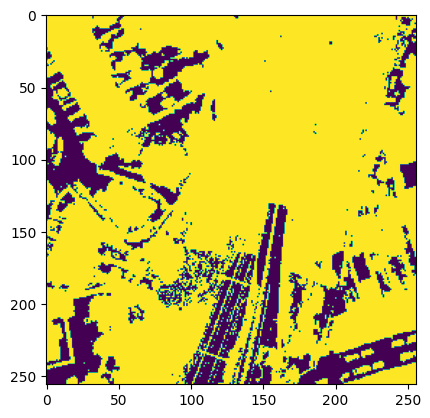

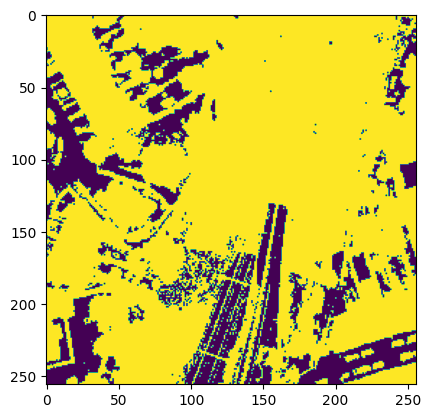

In [22]:
a = [i for i in ds.take(10)][1][1]
b = [i for i in ds1.take(10)][1][1]
plt.imshow(a)
plt.figure()
plt.imshow(b)

In [23]:
a == b

<tf.Tensor: shape=(256, 256, 1), dtype=bool, numpy=
array([[[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]],

       [[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]],

       [[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]]])>

In [ ]:
%tensorboard --logdir /home/student/data/logs/SEG --host 0.0.0.0

In [ ]:
histories = train_models(nets_to_train)

In [ ]:
reload(mod)

In [ ]:
train_10cm_ds, test_10cm_ds = make_seg_ds(256, 'train', threshold = 0.1), make_seg_ds(256, 'test', threshold = 0.1)
train_10cm_ds, test_10cm_ds = train_10cm_ds.batch(8), test_10cm_ds.batch(8)

In [ ]:
train_1_ds, test_1_ds = make_seg_ds(256, 'train'), make_seg_ds(256, 'test')
train_1_ds, test_1_ds = train_1_ds.batch(8), test_1_ds.batch(8)

In [ ]:
for i in test_1_ds.take(1):
    print(i)

In [ ]:
net = globals()['PixUnet']
inputs = tf.keras.layers.Input(shape=[256,256, 4])
net = net(inputs, relu=True, activ='sigmoid')
seg_1 = new_net(net, inputs)
train_new_model(seg_1, train_1_ds, test_1_ds, 'pix_1', 8708//8)

In [ ]:
pixNet = globals()['PixUnet']
inputs = tf.keras.layers.Input(shape=[256,256, 4])
pixNet = pixNet(inputs, relu=True, activ='sigmoid')
pixNet = new_net(pixNet, inputs)
checkpoint = tf.train.Checkpoint(model=pixNet)
checkpoint.restore('training_checkpoints/seg/pix20ep/ckpt-1')

In [ ]:
leaky_net = globals()['PixUnet']
inputs = tf.keras.layers.Input(shape=[256,256, 4])
leaky_net = leaky_net(inputs, relu=False, activ='sigmoid')
leaky_net = new_net(leaky_net, inputs)
checkpoint = tf.train.Checkpoint(model=leaky_net)
checkpoint.restore('training_checkpoints/seg/pix_sig/ckpt-1')

In [ ]:
train_new_model(leaky_net, train_dataset, test_dataset, 'leaky_net', 8708//8)

In [ ]:
train_dataset = make_seg_ds(512, 'train')
test_dataset = make_seg_ds(512, 'test')

batch_size=8
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

pixNet = globals()['PixUnet']
inputs = tf.keras.layers.Input(shape=[512,512, 4])
pixNet = pixNet(inputs, relu=True, activ='sigmoid')
pixNet = new_net(pixNet, inputs)
checkpoint = tf.train.Checkpoint(model=pixNet)
checkpoint.restore('training_checkpoints/seg/pix_512/ckpt-1')

train_new_model(pixNet, train_dataset, test_dataset, 'pix_512-10to20', 2177//8)